In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import GridSearchCV

## XGBoost Modelling

### Initial Model

In [26]:
train_test_data = pd.read_csv(r'E:\my-projs\wall-street-sentiments\data\train_test_data\train_test_data_new.csv')

In [27]:
train_test_data.dropna(inplace=True)
train_test_data

,timestamp,rank,ticker,name,mentions,mentioning_users,upvotes,sentiment,rank_24h_ago,mentions_24h_ago,...,return_on_equity_ttm,dividend_yield_annual,total_debt_to_equity_quarterly,revenue_growth_ttm_yoy,dividend_exists,rank_percentage_change_24h,mentions_percentage_change_24h,opening_price,closing_price,label
0,06-18-2023,2,AMD,AMD,56,42.0,112,67.0,4,54.0,...,2.4000,0.000000,0.0451,22.20,0,-0.500000,0.037037,125.82,120.08,0
1,06-18-2023,3,TSLA,Tesla,48,45.0,462,51.0,3,61.0,...,27.9000,0.000000,0.0557,38.34,0,0.000000,-0.213115,258.92,260.54,1
2,06-18-2023,4,NVDA,NVIDIA,44,41.0,262,57.0,2,88.0,...,20.8800,0.037512,0.4467,-12.40,1,1.000000,-0.500000,434.50,426.92,0
4,06-18-2023,7,AAPL,Apple,32,30.0,226,70.0,10,20.0,...,165.7200,0.516101,1.7635,-0.24,1,-0.300000,0.600000,186.73,184.92,0
5,06-18-2023,9,DTE,DTE Energy,23,22.0,146,56.0,6,44.0,...,11.7500,3.344746,1.8338,-15.52,1,0.500000,-0.477273,114.56,114.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,06-16-2023,7,PLTR,Palantir,184,84.0,588,65.0,12,53.0,...,-7.1566,0.000000,0.0000,20.50,0,-0.416667,2.471698,16.87,16.30,0
386,06-16-2023,8,MSFT,Microsoft,126,82.0,613,73.0,24,35.0,...,38.4600,0.781385,0.3322,7.81,1,-0.666667,2.600000,351.32,342.33,0
387,06-16-2023,9,SPCE,Virgin Galactic,125,99.0,739,68.0,164,3.0,...,1.8000,0.000000,1.1349,-33.95,0,-0.945122,40.666667,5.72,4.73,0
388,06-16-2023,10,NKLA,Nikola,117,79.0,285,75.0,10,56.0,...,1.1500,0.000000,0.5830,3082.56,0,0.000000,1.089286,1.70,1.19,0


In [28]:
# Remove columns that are not needed for modelling

train_test_data = train_test_data.drop(
    ['name', 
     'ticker', 
     'timestamp',
    'opening_price',
   'closing_price',
   'rank_24h_ago',
   'mentions_24h_ago',
   'rank', 'dividend_exists'
    ], axis=1).sort_values(
    by=['mentions'], 
    ascending=False)

In [65]:
train_test_data.columns

Index(['mentions', 'mentioning_users', 'upvotes', 'sentiment', 'beta',
       'earnings_per_share_ttm', 'price_to_equity_ttm', 'return_on_equity_ttm',
       'dividend_yield_annual', 'total_debt_to_equity_quarterly',
       'revenue_growth_ttm_yoy', 'rank_percentage_change_24h',
       'mentions_percentage_change_24h', 'label'],
      dtype='object')

In [30]:
train_test_data.value_counts('label')

label
1    210
0    170
Name: count, dtype: int64

In [35]:
x_train, x_test, y_train, y_test = train_test_split(train_test_data.drop('label', axis=1), train_test_data['label'], test_size=0.3, random_state=42)

In [36]:
# xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.41      0.45        51
           1       0.58      0.65      0.61        63

    accuracy                           0.54       114
   macro avg       0.53      0.53      0.53       114
weighted avg       0.54      0.54      0.54       114



In [33]:
# Training accuracy

y_pred_train = xgb_model.predict(x_train)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       147

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



### Hyper-parameter tuning

In [62]:
# xgboost hyperparameter tuning

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0, 1.0, 10.0, 100.0],
    'scale_pos_weight': [1, 3, 5]
}

# random search
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=5,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=3
)

random_search.fit(x_train, y_train)

print(random_search.best_estimator_)

print(random_search.best_params_)

print(random_search.best_score_)

y_pred = random_search.predict(x_test)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)
{'scale_pos_weight': 3, 'reg_lambda': 0, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.25}
0.5375649675162419
              precision    recall  f1-score   support

           0       0.45      0.27      0.34        51
           1       0.55      0.7

In [43]:
# Training accuracy

y_pred_train = random_search.predict(x_train)

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00       147

    accuracy                           1.00       266
   macro avg       1.00      1.00      1.00       266
weighted avg       1.00      1.00      1.00       266



In [57]:
import joblib
from datetime import datetime
joblib.dump(random_search.best_estimator_, f'E:/my-projs/wall-street-sentiments/experimentation/models/xgboost_{datetime.now().strftime("%Y-%m-%d%H-%M-%S")}.joblib')

['E:/my-projs/wall-street-sentiments/experimentation/models/xgboost_2023-07-2316-40-46.joblib']

### Visuallizing feature importance

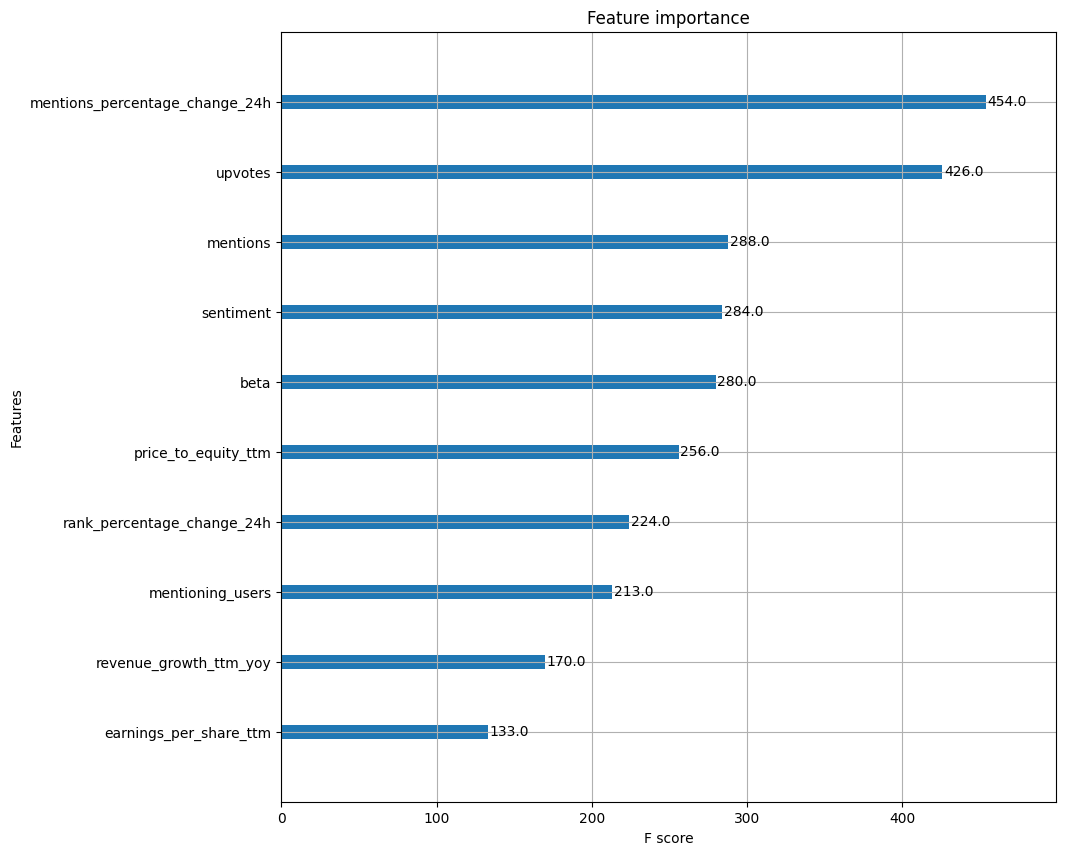

In [24]:
# visuallizing feature importnace

import matplotlib.pyplot as plt

xgb.plot_importance(random_search.best_estimator_, max_num_features=10)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()